In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, Module, ModuleList
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from torch_frame.data import Dataset, DataLoader
from torch_frame import TensorFrame, stype
from torch_frame.nn.conv import TabTransformerConv
from torch_frame.nn.encoder import (
    EmbeddingEncoder,
    LinearEncoder,
    StypeWiseFeatureEncoder,
)


def prepare_dataset(df, one_hot=False):
    # Encode categorical features with one hot, and replace NA with "Missing"
    # With one hot encoding support
    categorical_columns = df.select_dtypes(include=['object']).columns
    for key in categorical_columns:
        df[key] = df[key].astype('category').cat.add_categories("Missing").fillna("Missing")
    if not one_hot:
        return df
    
    categorical_columns = df.select_dtypes(include=['category']).columns
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(df[categorical_columns])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns.to_list()))
    df = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)
    return df

In [19]:
train_file_path = "data/house-prices/train.csv"
dataset_df = pd.read_csv(train_file_path)
dataset_df = dataset_df.drop('Id', axis=1)
target_column = 'SalePrice'
dataset_df = prepare_dataset(dataset_df, False)


# Preprocessing
from sklearn.preprocessing import QuantileTransformer

numerical_cols = dataset_df.select_dtypes(exclude=['category']).columns.drop(target_column)

# 1. QuantileTransformer applied to numerical features
quant_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
dataset_df[numerical_cols] = quant_transformer.fit_transform(dataset_df[numerical_cols])

# 2. Log transform applied to target
dataset_df[target_column] = np.log(dataset_df[target_column])

# Build frame
col_to_stype = {key: stype.categorical for key in dataset_df.select_dtypes(include=['category']).columns.to_list()}
col_to_stype.update({key: stype.numerical for key in dataset_df.select_dtypes(exclude=['category']).columns.to_list()})
dataset = Dataset(dataset_df, col_to_stype=col_to_stype, target_col=target_column)
dataset.materialize()

dataset.tensor_frame

# dataset.tensor_frame.num_cols


TensorFrame(
  num_cols=79,
  num_rows=1460,
  categorical (43): ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities'],
  numerical (36): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', '

In [20]:
class ExampleTransformer(Module):
    def __init__(
        self,
        channels, out_channels, num_layers, num_heads,
        col_stats, col_names_dict,
    ):
        super().__init__()
        self.encoder = StypeWiseFeatureEncoder(
            out_channels=channels,
            col_stats=col_stats,
            col_names_dict=col_names_dict,
            stype_encoder_dict={
                stype.categorical: EmbeddingEncoder(),
                stype.numerical: LinearEncoder()
            },
        )
        self.convs = ModuleList([
            TabTransformerConv(
                channels=channels,
                num_heads=num_heads,
            ) for _ in range(num_layers)
        ])
        self.decoder = Linear(channels, out_channels)

    def forward(self, tf: TensorFrame) -> Tensor:
        x, _ = self.encoder(tf)   # x.shape = [batch_size, num_features, channels]
        for conv in self.convs:
            x = conv(x)
        out = self.decoder(x.mean(dim=1))
        return out
    
class MLP(Module):
    """MLP with ReLU activation"""
    def __init__(self, channels, hidden_layers, out_channels, num_cols, col_stats, col_names_dict, stype_encoder_dict):
        super().__init__()
        self.encoder = StypeWiseFeatureEncoder(
            out_channels=channels,
            col_stats=col_stats,
            col_names_dict=col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        )
        hidden_layers = [num_cols * channels] + hidden_layers
        self.layers = ModuleList([nn.Sequential(nn.Linear(hidden_layers[i], hidden_layers[i + 1]), nn.ReLU()) for i in range(len(hidden_layers) - 1)])
        self.decoder = nn.Linear(hidden_layers[-1], out_channels)

    def forward(self, tf: TensorFrame) -> Tensor:
        x, _ = self.encoder(tf)   # x.shape = [batch_size, num_features, channels]
        bsz = x.shape[0]
        x = x.view(bsz, -1)
        for layer in self.layers:
            x = layer(x)
        out = self.decoder(x)
        return out

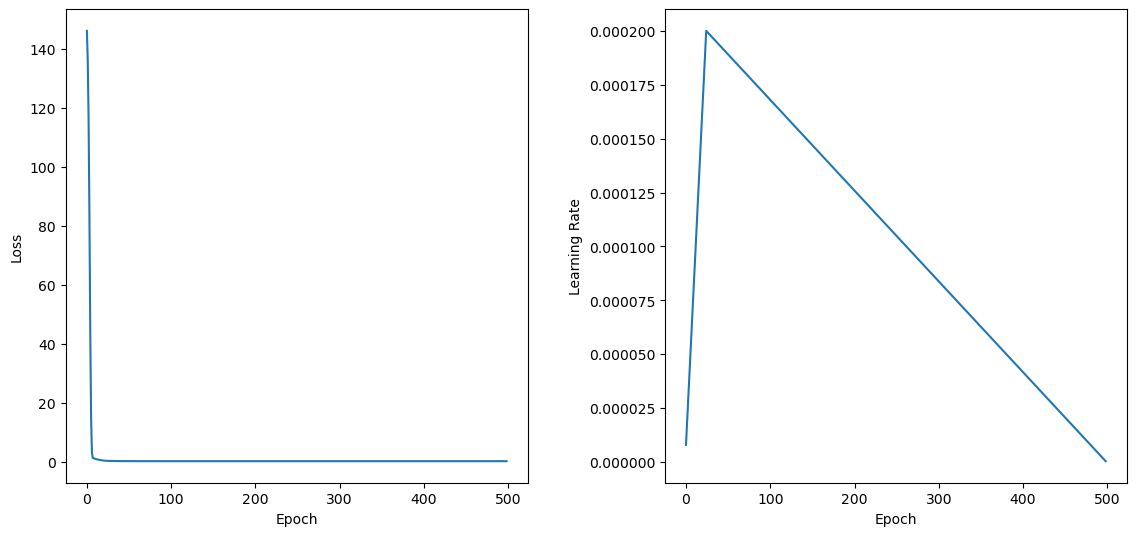

In [21]:
stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: LinearEncoder(),
}

device = 'cuda:5'

# from torch_frame.nn.models.ft_transformer import FTTransformer
# model = FTTransformer(
#     channels=16,
#     out_channels=1,
#     num_layers=2,
#     col_stats=dataset.col_stats,
#     col_names_dict=dataset.tensor_frame.col_names_dict,
#     stype_encoder_dict=stype_encoder_dict,
# ).to(device)

# model = ExampleTransformer(
#     channels=16,
#     out_channels=1,
#     num_layers=2,
#     num_heads=8,
#     col_stats=dataset.col_stats,
#     col_names_dict=dataset.tensor_frame.col_names_dict,
# ).to(device)

model = MLP(16, [512], 1, dataset.tensor_frame.num_cols, dataset.col_stats, dataset.tensor_frame.col_names_dict, stype_encoder_dict).to(device)
# print(model)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Initial setup for the first plot
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Initial setup for the second plot
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

num_epochs = 500
batch_size = 64
steps_per_epoch = len(dataset) // batch_size
num_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.05 * num_steps)

train_loader = DataLoader(dataset.tensor_frame, batch_size=batch_size,
                          shuffle=True, drop_last=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=1e-5)
# Setup the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps,  # Example values
                                            num_training_steps=num_steps)

loss_list = [None] * num_epochs
lr_list = [None] * num_epochs
for epoch in range(num_epochs):
    # print('===Epoch {}==='.format(epoch))
    total_loss = 0
    total_bsz = 0
    for tf in train_loader:
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.mse_loss(pred, tf.y)
        bsz = len(tf.y)
        total_loss += loss.item() * bsz
        total_bsz += bsz
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # print('average loss = {}'.format(total_loss / total_bsz))
    loss_list[epoch] = total_loss / total_bsz
    lr_list[epoch] = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        ax1.cla()
        ax2.cla()
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Learning Rate')
        ax1.plot(loss_list[:epoch])
        ax2.plot(lr_list[:epoch])
        plt.tight_layout(pad=3.0)
        display(fig)
        clear_output(wait=True)

In [22]:
print(model)

MLP(
  (encoder): StypeWiseFeatureEncoder(
    (encoder_dict): ModuleDict(
      (categorical): EmbeddingEncoder(
        (emb): Embedding(295, 16, padding_idx=0)
      )
      (numerical): LinearEncoder()
    )
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1264, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Linear(in_features=512, out_features=1, bias=True)
)


In [23]:
torch.exp(model.forward(dataset.tensor_frame.to(device)))

tensor([[166795.5000],
        [168585.3281],
        [167270.3438],
        ...,
        [169080.5938],
        [165567.8906],
        [166687.3594]], device='cuda:5', grad_fn=<ExpBackward0>)

In [24]:
test_file_path = "data/house-prices/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_data = prepare_dataset(test_data, False)
test_data = test_data.reindex(columns=dataset_df.columns.drop(target_column), fill_value=0)  # Add the missing columns from X, and fill values to be 0

numerical_cols = test_data.select_dtypes(exclude=['category']).columns
test_data[numerical_cols] = quant_transformer.transform(test_data[numerical_cols])


col_to_stype = {key: stype.categorical for key in test_data.select_dtypes(include=['category']).columns.to_list()}
col_to_stype.update({key: stype.numerical for key in test_data.select_dtypes(exclude=['category']).columns.to_list()})
test_dataset = Dataset(test_data, col_to_stype=col_to_stype)
test_dataset.materialize()

sample_submission_df = pd.read_csv('data/house-prices/sample_submission.csv')
pred = torch.exp(model(test_dataset.tensor_frame.to(device)))
sample_submission_df['SalePrice'] = pred.detach().cpu().numpy()
sample_submission_df.to_csv('working/mlp-quant-log.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,166135.390625
1,1462,176131.843750
2,1463,166882.046875
3,1464,180358.046875
4,1465,171917.250000
